## Imports

In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score

from skopt import BayesSearchCV

import shap

import warnings
warnings.filterwarnings("ignore")

## Read Dataset

In [9]:
data = pd.read_csv("data/Heart_Disease_Kaggle_Preprocessed.csv")
print(data.shape)
data.head()

(268, 14)


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,ECG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,1.733026,0.681528,0.871534,-0.064103,1.407389,-0.418854,0.977857,-1.777056,-0.699206,1.193857,0.680101,2.462874,-0.881493,1
1,1.400801,-1.467290,-0.180588,-0.914581,6.109512,-0.418854,0.977857,0.437459,-0.699206,0.491048,0.680101,-0.715538,1.181740,0
2,0.293383,0.681528,-1.232710,-0.404294,0.222143,-0.418854,-1.022644,-0.387556,-0.699206,-0.651016,-0.947283,-0.715538,1.181740,1
3,1.068576,0.681528,0.871534,-0.177500,0.261004,-0.418854,-1.022644,-1.950743,1.430194,-0.738867,0.680101,0.343933,1.181740,0
4,2.175994,-1.467290,-1.232710,-0.631088,0.377585,-0.418854,0.977857,-1.255994,1.430194,-0.738867,-0.947283,0.343933,-0.881493,0


## Data split

In [10]:
X = data.drop(columns=["Heart Disease"])
y = data["Heart Disease"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Metrics settings

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fbeta_scorer = make_scorer(fbeta_score, beta=2)

scoring_metrics = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "fbeta_2": fbeta_scorer,
    "roc_auc": "roc_auc"
}

## Cross-validation

In [12]:
lr = LogisticRegression()
scores_lr = cross_validate(lr, X, y, cv=cv, scoring=scoring_metrics)

print("Scores Logistic Regression:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_lr[f"test_{metric}"])
    std_score = np.std(scores_lr[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

Scores Logistic Regression:
Accuracy: 0.8392 ± 0.0969
Precision: 0.8222 ± 0.0947
Recall: 0.8080 ± 0.1454
Fbeta_2: 0.8097 ± 0.1348
Roc_auc: 0.9055 ± 0.0796


## Bayesian Optimization

In [13]:
search_space = {
    'C': (1e-4, 1e+3, 'log-uniform'),  # regularization strength
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' supports both l1 and l2
}

lr_opt = BayesSearchCV(
    LogisticRegression(max_iter=1000),
    search_spaces=search_space,
    scoring="roc_auc",  # Use ROC AUC directly
    cv=cv,
    n_iter=30,
    n_jobs=-1,
    random_state=42
)

lr_opt.fit(X, y)

best_params = lr_opt.best_params_

print("Best parameters:", best_params)
print("Best ROC AUC score (cv):", lr_opt.best_score_)

Best parameters: OrderedDict([('C', 0.12996535162010367), ('penalty', 'l2'), ('solver', 'liblinear')])
Best ROC AUC score (cv): 0.9097851074462768


## Cross-validation with best model

In [14]:
lr = LogisticRegression(**best_params)
scores_lr = cross_validate(lr, X, y, cv=cv, scoring=scoring_metrics)

print("Scores Logistic Regression:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_lr[f"test_{metric}"])
    std_score = np.std(scores_lr[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

Scores Logistic Regression:
Accuracy: 0.8467 ± 0.0980
Precision: 0.8317 ± 0.0957
Recall: 0.8163 ± 0.1406
Fbeta_2: 0.8185 ± 0.1307
Roc_auc: 0.9098 ± 0.0804


## Feature Importance | SHAP

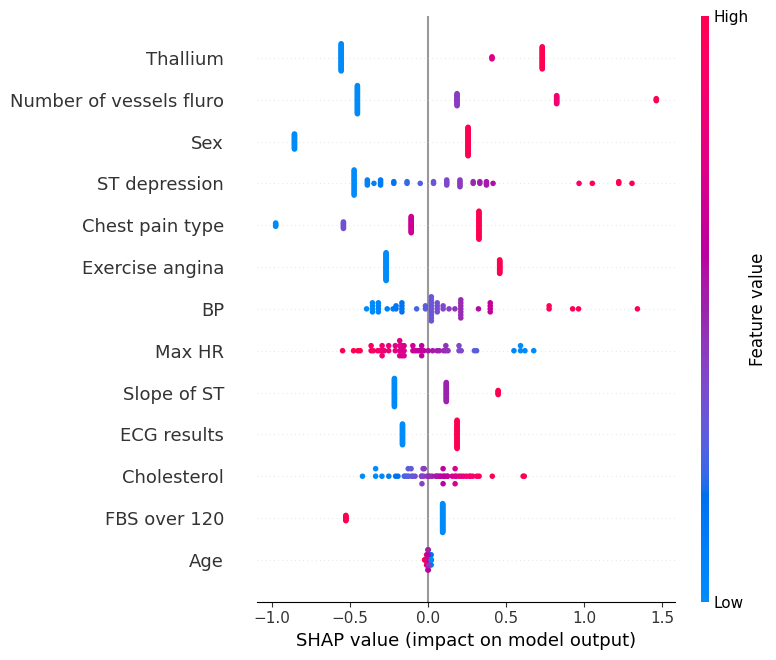

In [15]:
lr.fit(X_train, y_train)
explainer = shap.LinearExplainer(lr, X_train)  # Optimized for linear models
shap_values = explainer.shap_values(X_test)  # Compute SHAP values

# Feature importance visualization
shap.summary_plot(shap_values, X_test)